# Setup

### Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

### Loading CSV into DataFrames

In [11]:
df_categories = pd.read_csv('steam_data/categories.csv')
df_games = pd.read_csv('steam_data/games.csv', quotechar='"', escapechar="\\", encoding="utf-8", on_bad_lines="skip")
df_genres = pd.read_csv('steam_data/genres.csv')
df_reviews = pd.read_csv('steam_data/reviews.csv', quotechar='"', escapechar="\\", encoding="utf-8", on_bad_lines="skip")
df_tags = pd.read_csv('steam_data/tags.csv')
df_steamspy_insights = pd.read_csv('steam_data/steamspy_insights.csv', quotechar='"', escapechar="\\", encoding="utf-8", on_bad_lines="skip")

C:\Users\Jonas\AppData\Local\Temp\ipykernel_14184\574882810.py:4: DtypeWarning: Columns (1,3,4,5,9,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews = pd.read_csv('steam_data/reviews.csv', quotechar='"', escapechar="\\", encoding="utf-8", on_bad_lines="skip")


### Pre_Processing

Converting json-like object in price_overview column into separate column for easier usage

In [12]:
def extract_price_info(price_str):
    try:
        data = json.loads(price_str)
    except (TypeError, json.JSONDecodeError):
        return pd.Series({
            'final': None,
            'initial': None,
            'currency': None,
            'final_formatted': None,
            'discount_percent': None,
            'initial_formatted': None,
        })
    return pd.Series({
        'final': data.get('final'),
        'initial': data.get('initial'),
        'currency': data.get('currency'),
        'final_formatted': data.get('final_formatted'),
        'discount_percent': data.get('discount_percent'),
        'initial_formatted': data.get('initial_formatted'),
    })

Inserting new column into games table

In [13]:
price_details = df_games['price_overview'].apply(extract_price_info)
df_games = pd.concat([df_games, price_details], axis=1)

# to remvoe the original 'price_overview' column
df_games = df_games.drop(columns=['price_overview'])

Cleaning the 'languages' column from <\br> <\strong> and * signs

In [14]:
# <strong> tags
df_games['languages'] = df_games['languages'].str.replace(r'</?strong>', '', regex=True)

# <br> tags (covers <br>, <br/>, or <br />)
df_games['languages'] = df_games['languages'].str.replace(r'</?br\s*/?>', '', regex=True)


# asterisks (*)
df_games['languages'] = df_games['languages'].str.replace('*', '', regex=False)

# to remove space before and the phrase "with full audio support"
df_games['languages'] = df_games['languages'].str.replace(r'\s*with full audio support', '', regex=True)

Creating polished CSV

In [15]:
df_games.to_csv('steam_data/games_cleaned.csv', index=False)

# EDA

### Top 20 most categorized games

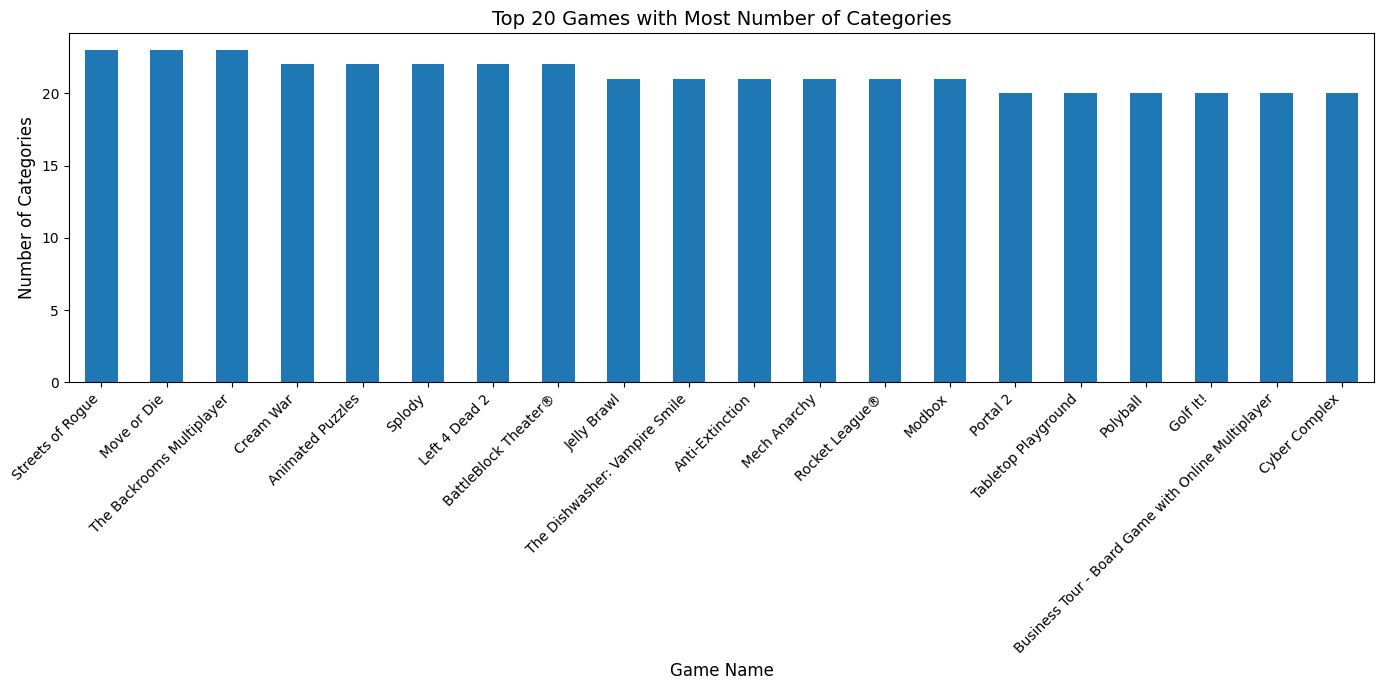

In [29]:
# Count the number of categories for each game
category_count_df = df_categories.groupby('app_id').size().reset_index(name='category_count')

# Merge with the games dataframe to get the game names
category_count_df = category_count_df.merge(df_games[['app_id', 'name']], on='app_id')

# Define a var for the top 20 games with the most categories
top_20_category_count_df = category_count_df.sort_values(by='category_count', ascending=False).head(20)

# Plot the dataset
plt.figure(figsize=(14, 7))
top_20_category_count_df.plot(x='name', y='category_count', kind='bar', legend=False, ax=plt.gca())
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.xlabel('Game Name', fontsize=12)
plt.ylabel('Number of Categories', fontsize=12)
plt.title('Top 20 Games with Most Number of Categories', fontsize=14)
plt.tight_layout()
plt.show()


### 10 most popular game genres

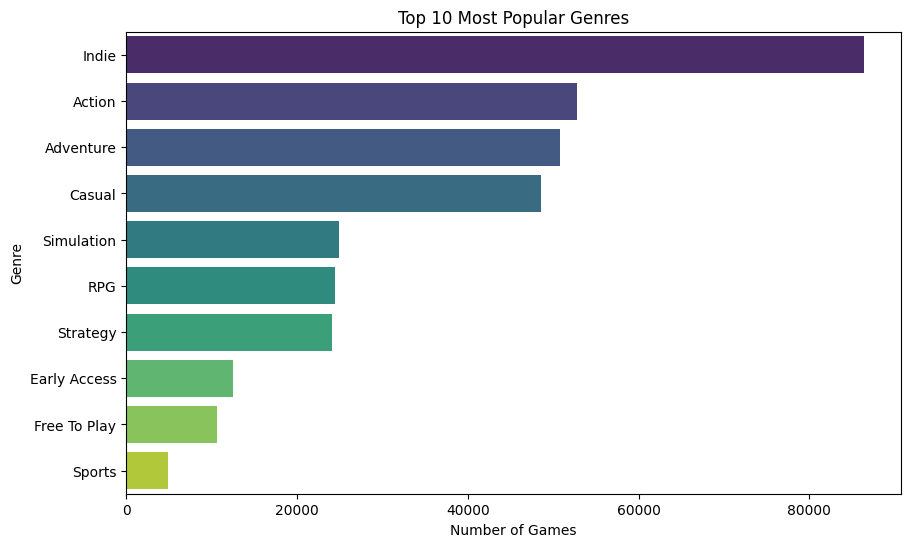

In [28]:
# Count the number of games in each genre
genre_counts = df_genres['genre'].value_counts().head(10)

# Plot the top 10 genres
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis', hue=genre_counts.index, legend=False)
plt.title('Top 10 Most Popular Genres')
plt.xlabel('Number of Games')
plt.ylabel('Genre')
plt.show()

### Looking at the amount of indie games on steam

In [32]:
# Count the number of indie games
indie_games_count = df_genres[df_genres['genre'] == 'Indie'].shape[0]

# Count the total number of games
total_games_count = df_genres.shape[0]

# Calculate the number of non-indie games
non_indie_games_count = total_games_count - indie_games_count

print(f"Number of Indie games: {indie_games_count}")
print(f"Number of Non-Indie games: {non_indie_games_count}")
print(f"Total number of games: {total_games_count}")

print(total_games_count/indie_games_count)

Number of Indie games: 86425
Number of Non-Indie games: 266914
Total number of games: 353339
4.0883887763957185


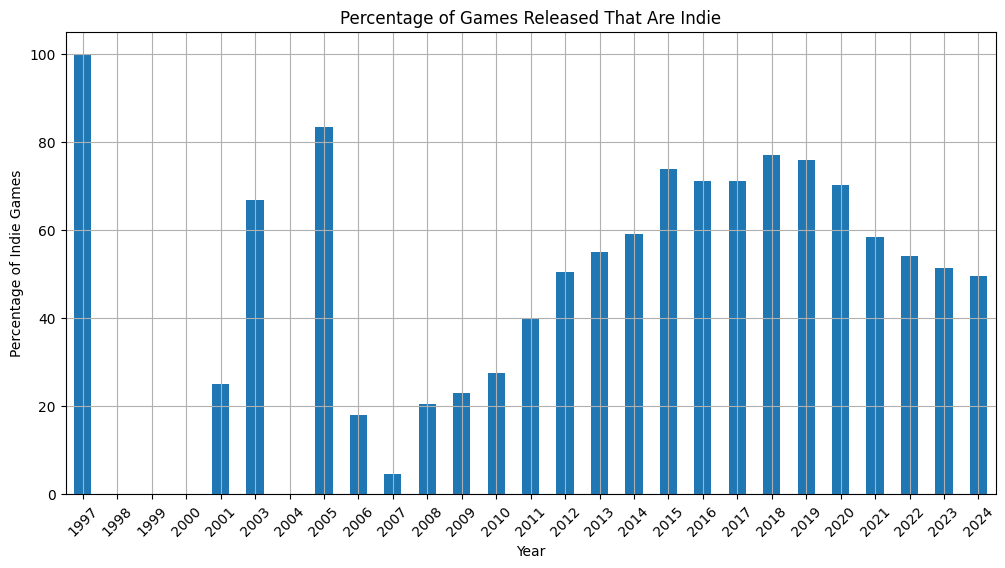

In [39]:
# Extract the release year from the release_date column
df_games['release_year'] = pd.to_datetime(df_games['release_date'], errors='coerce').dt.year

# Merge df_games with df_genres to get the genre information
df_games_genres = df_games.merge(df_genres, on='app_id')

# Calculate the number of indie games released each year
indie_games_per_year = df_games_genres[df_games_genres['genre'] == 'Indie'].groupby('release_year').size()

# Calculate the total number of games released each year
total_games_per_year = df_games.groupby('release_year').size()

# Calculate the ratio of indie games to total games released each year
indie_ratio_per_year = (indie_games_per_year / total_games_per_year) * 100

# Plot the ratio of indie games released over time as a bar plot
plt.figure(figsize=(12, 6))
indie_ratio_per_year.plot(kind='bar')
plt.title('Percentage of Games Released That Are Indie')
plt.xlabel('Year')
plt.ylabel('Percentage of Indie Games')
plt.grid(True)
plt.xticks(ticks=range(len(indie_ratio_per_year.index)), labels=indie_ratio_per_year.index.astype(int), rotation=45)
plt.show()